In [110]:
import numpy as np
import pandas as pd
import torch
import os
import glob

from torch.utils.data import Dataset, DataLoader

from PIL import Image
import random

from torchvision import transforms

from matplotlib import pyplot as plt

import warnings

warnings.filterwarnings("ignore")

In [48]:
folders = os.listdir("Stanford_Online_Products")
folders = [folder for folder in folders if ("_final" in folder) and (".txt" not in folder)]

In [49]:
folders

['bicycle_final',
 'cabinet_final',
 'chair_final',
 'coffee_maker_final',
 'fan_final',
 'kettle_final',
 'lamp_final',
 'mug_final',
 'sofa_final',
 'stapler_final',
 'table_final',
 'toaster_final']

In [50]:
labels = folders

In [ ]:
df_train = pd.read_txt("E")

In [53]:
for filename in glob.glob("Stanford_Online_Products/*.txt"):
    print(filename)
    with open(filename, 'r') as f:
        label = filename.split("\\").split(".")[0]
        labels.append(label)


Stanford_Online_Products\bicycle_final.txt
Stanford_Online_Products\cabinet_final.txt
Stanford_Online_Products\chair_final.txt
Stanford_Online_Products\coffee_maker_final.txt
Stanford_Online_Products\Ebay_final.txt
Stanford_Online_Products\Ebay_info.txt
Stanford_Online_Products\Ebay_test.txt
Stanford_Online_Products\Ebay_train.txt
Stanford_Online_Products\fan_final.txt
Stanford_Online_Products\kettle_final.txt
Stanford_Online_Products\lamp_final.txt
Stanford_Online_Products\mug_final.txt
Stanford_Online_Products\sofa_final.txt
Stanford_Online_Products\stapler_final.txt
Stanford_Online_Products\table_final.txt
Stanford_Online_Products\toaster_final.txt


In [70]:
df_train = pd.read_csv("Stanford_Online_Products/Ebay_train.txt", sep=' ', skiprows=1, names=["image_id", "class_id", "super_class_id", "path"], index_col="image_id")

In [84]:
df_train

,class_id,super_class_id,path
image_id,,,
1,1,1,bicycle_final/111085122871_0.JPG
2,1,1,bicycle_final/111085122871_1.JPG
3,1,1,bicycle_final/111085122871_2.JPG
4,1,1,bicycle_final/111085122871_3.JPG
5,1,1,bicycle_final/111085122871_4.JPG
...,...,...,...
59547,11318,12,toaster_final/221852410489_0.JPG
59548,11318,12,toaster_final/221852410489_1.JPG
59549,11318,12,toaster_final/221852410489_2.JPG


In [82]:
PATH = "Stanford_Online_Products"
IMAGE_SIZE = 256

In [87]:
class ProductDataset(Dataset):
    def __init__(self, df, path, train=True, transform=None):
        self.data_csv = df
        self.is_train = train
        self.transform = transform
        self.path = path
        if self.is_train:
            self.images = df["path"].values
            self.labels = df["class_id"].values
            self.index = df.index.values


    def __len__(self):
        return len(self.images)


    def __getitem__(self, item):
        anchor_image_name = self.images[item]
        anchor_image_path = self.path + "/" + anchor_image_name
        ###### Anchor Image #######
        anchor_img = Image.open(anchor_image_path).convert("RGB")
        if self.is_train:
            anchor_label = self.labels[item]
            positive_list = self.index[self.index!=item][self.labels[self.index!=item]==anchor_label]
            positive_item = random.choice(positive_list)
            positive_image_name = self.images[positive_item]
            positive_image_path = self.path + "/" + positive_image_name
            positive_img = Image.open(positive_image_path).convert("RGB")
            #positive_img = self.images[positive_item].reshape(28, 28, 1)
            negative_list = self.index[self.index!=item][self.labels[self.index!=item]!=anchor_label]
            negative_item = random.choice(negative_list)
            negative_image_name = self.images[negative_item]
            negative_image_path = self.path + "/" +  negative_image_name
            negative_img = Image.open(negative_image_path).convert("RGB")
            #negative_img = self.images[negative_item].reshape(28, 28, 1)
            if self.transform!=None:
                anchor_img = self.transform(anchor_img)
                positive_img = self.transform(positive_img)
                negative_img = self.transform(negative_img)
        return anchor_img, positive_img, negative_img, anchor_label




transform=transforms.Compose([transforms.ToTensor(),
                              transforms.Resize((IMAGE_SIZE, IMAGE_SIZE))
                              ])

In [93]:
trainDS = ProductDataset(df=df_train, path=PATH, train=True, transform=transform)

In [94]:
BATCH_SIZE = 64

In [95]:
trainLoader = DataLoader(trainDS,batch_size=BATCH_SIZE, shuffle=True)

In [111]:
anchors, positives, negatives, labels = next(iter(trainLoader))

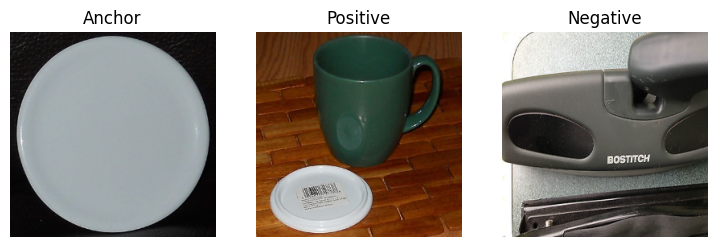

In [112]:
plt.figure(figsize=(9,18))
plt.subplot(1,3,1)
plt.imshow(anchors[0].permute(1, 2, 0))
plt.axis("off")
plt.title("Anchor")

plt.subplot(1,3,2)
plt.imshow(positives[0].permute(1, 2, 0))
plt.axis("off")
plt.title("Positive")

plt.subplot(1,3,3)
plt.imshow(negatives[0].permute(1, 2, 0))
plt.axis("off")
plt.title("Negative")

plt.show()